In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from src.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools
import os

from src.utils import user_topic_mapping as user_topic_mapping_func
from src.plotting import *
from src.cluster_functions import *

In [2]:
from sklearn.preprocessing import StandardScaler

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

In [3]:



# def merge_diagnostics_results(folder_paths, file_names, diagnostics_vars=["mean", "std", "median", "min", "max", "skew"]):
#     assert (len(folder_paths) == len(file_names)), "Must supply same number of folder paths and file names"
#     model_diagnostics = defaultdict(lambda: defaultdict(list))
#     final_diagnostics = defaultdict(lambda: defaultdict(list))
#     for idx in range(len(folder_paths)):
#         results = load_sim_results(folder_paths[idx], file_names[idx])
        
#         for metric_name, model in results.items():
#             for model_name, diagnostic in model.items():
#                 for diag, diag_vals in diagnostic.items():
#                     model_diagnostics[metric_name][diag] = diag_vals 
#                 for metric in model_diagnostics:
#                     final_diagnostics[metric][model_name] = model_diagnostics[metric]
#     return final_diagnostics


# def calculate_cluster_switch(user_to_item_cluster_assignment, final_user_pref_mapping, model):
#     data = []
#     data.append(user_to_item_cluster_assignment)
#     data.append(final_user_pref_mapping)
#     data = np.array(data).T
#     cluster_changes_df = pd.DataFrame(data, columns=['initial_cluster', 'final_cluster'])
#     cluster_changes_df = cluster_changes_df[cluster_changes_df['initial_cluster'] != cluster_changes_df['final_cluster']]
#     print(model, ': Number of people who changed clusters: ', cluster_changes_df.shape[0])
#     return cluster_changes_df.shape[0]

In [4]:
# def plot_tsne_3_comparison(dfs, titles, fig_title, n_clusters):
#     """
#     Plots two tsne plots (before and after simulation) with convex hulls.
    
#     Parameters
#     ----------
#     df : pd.DataFrame
#         Dataframe with columns 'comp-1', 'comp-2' and 'y'
#     perplexity : int
#         Perplexity for tsne
#     """
#     fig, axs = plt.subplots(1, 3, figsize=(20, 10))

#     palette = sns.color_palette(cc.glasbey, n_colors=n_clusters)

#     plot_clusters(dfs[0], axs[0], palette)
#     axs[0].set_title(titles[0])
#     plot_clusters(dfs[1], axs[1], palette, previously_seen=dfs[1].y.unique())
#     axs[1].set_title(titles[1])
#     plot_clusters(dfs[2], axs[2], palette, previously_seen=dfs[2].y.unique())
#     axs[2].set_title(titles[2])

#     plt.suptitle(fig_title)
#     plt.show()

In [5]:
results_paths = {
    'repeated_training': ['sim_results/simulation1/repeated_training'],
    'single_training': ['sim_results/simulation1/single_training'],
}
num_sims = 1

environment_file = ["sim_environment.pkl"]

repeated_training_env = merge_results(results_paths['repeated_training'], environment_file)
single_training_env = merge_results(results_paths['single_training'], environment_file)

environments = {
    'repeated_training': repeated_training_env,
    'single_training': single_training_env
}

env_keys = list(repeated_training_env.keys())
model_keys = list(repeated_training_env[env_keys[0]].keys())

print(len(env_keys), env_keys)
print(len(model_keys), model_keys)

9 ['actual_user_representation_initial', 'actual_user_representation_final', 'user_cluster_assignments', 'user_cluster_centroids', 'item_representation', 'item_cluster_assignments', 'item_cluster_centroids', 'global_user_centroid', 'user_item_cluster_mapping']
9 ['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25']


# PCA Plots - User representations by cluster

In [6]:
user_representation_initial = repeated_training_env['actual_user_representation_initial']
user_representation_initial = list(user_representation_initial.values())[0][0]

In [7]:
all_user_representation_final = {}

for model in repeated_training_env['actual_user_representation_final'].keys():
    all_user_representation_final[model] = repeated_training_env['actual_user_representation_final'][model][0]

all_user_representation_final.keys()

dict_keys(['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25'])

In [8]:
# Plot PCA for initial v. final user representation for all models, single training type
n_clusters = 15

initial_user_representation_df = pd.DataFrame(StandardScaler().fit_transform(user_representation_initial))
initial_user_representation_df['Cluster'] = list(repeated_training_env['user_cluster_assignments'].values())[0][0]
initial_fig = plot_pca_3d_subplots(initial_user_representation_df, n_clusters)

final_rep_figs = []
subplot_titles = ["initial"]
for model in all_user_representation_final:
    subplot_titles.append(model)
    final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(all_user_representation_final[model]))
    final_user_rep_df['Cluster'] = list(repeated_training_env['user_cluster_assignments'].values())[0][0]
    final_rep_figs.append(plot_pca_3d_subplots(final_user_rep_df, n_clusters))

num_rows, num_cols = 4, 3

num_subplots = 9
fig_results = make_subplots(
    rows=num_rows, cols=num_cols,
    subplot_titles=subplot_titles,
    specs=[[{'type':'scene'}, None, None],
           [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}],
           [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}],
           [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]],
    horizontal_spacing = 0.1,
    vertical_spacing = 0.1
)

# print(fig_results.print_grid)
for d in initial_fig.data:
    fig_results.add_trace(d, row=1, col=1)

fig_idx = 0    
for row in range(2, num_rows+1):
    for col in range(1, num_cols+1):
        for d in final_rep_figs[fig_idx].data:
            fig_results.append_trace(d, row=row, col=col)
        fig_idx += 1


fig_results.layout.update(height=1500, width=1800, showlegend=False)    
fig_results.show()


In [9]:
# Plot 3D PCA for single model, single training v. repeated training

n_clusters = 15

model_names = list(single_training_env['actual_user_representation_initial'].keys())
plot_model = model_names[1]
print(plot_model)

curr_model_user_representation_final = {
    "single_training":single_training_env['actual_user_representation_final'][plot_model][0],
    "repeated_training":repeated_training_env['actual_user_representation_final'][plot_model][0],
}

user_cluster_assignments = repeated_training_env['user_cluster_assignments'][plot_model][0]
assert(np.array_equal(user_cluster_assignments, single_training_env['user_cluster_assignments'][plot_model][0]))

initial_user_representation_df = pd.DataFrame(StandardScaler().fit_transform(user_representation_initial))
initial_user_representation_df['Cluster'] = user_cluster_assignments
initial_fig = plot_pca_3d_subplots(initial_user_representation_df, n_clusters)

final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(curr_model_user_representation_final["single_training"]))
final_user_rep_df['Cluster'] = user_cluster_assignments
final_single_training_fig = plot_pca_3d_subplots(final_user_rep_df, n_clusters)

final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(curr_model_user_representation_final["repeated_training"]))
final_user_rep_df['Cluster'] = user_cluster_assignments
final_repeated_training_fig = plot_pca_3d_subplots(final_user_rep_df, n_clusters)

fig_results = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Initial user representation', 'Single training', 'Repeated training'],
    specs=[[{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]],
    horizontal_spacing = 0.1,
    vertical_spacing = 0.1
)

# print(fig_results.print_grid)
for d in initial_fig.data:
    fig_results.add_trace(d, row=1, col=1)
for f1 in final_single_training_fig.data:
    fig_results.add_trace(f1, row=1, col=2)
for f2 in final_repeated_training_fig.data:
    fig_results.add_trace(f2, row=1, col=3)


# fig_results.layout.update(height=400, width=1000, showlegend=False, title_text=plot_model)  
fig_results.layout.update(height=400, width=1000, title_text=plot_model)    
fig_results.show()


repeated_items_repeat_interactions


# t-SNE plots

In [10]:
env_keys_labels = [
    'actual_user_representation_initial',
    'actual_user_representation_final',
    'user_cluster_assignments_initial',
    'user_cluster_centroids',
    'item_representation',
    'item_cluster_assignments',
    'item_cluster_centroids',
    'global_user_centroid',
    'user_item_cluster_mapping_initial'
]

model_names_readable = {
    'baseline_myopic':'Myopic',
    'repeated_items_repeat_interactions':'Repeatable',
    'probabilistic':'Probabilistic',
    'random':'Random',
    'random_interleaving':'Random Interleaving',
    'xquad_binary_0.1': "Binary XquAD, alpha=0.1",
    'xquad_binary_0.25': "Binary XquAD, alpha=0.25",
    'xquad_smooth_0.1': "Smooth XquAD, alpha=0.1",
    'xquad_smooth_0.25': "Smooth XquAD, alpha=0.25"
}
training_readable = {
    'single_training':'Single Training',
    'repeated_training':'Repeated Training'
}

## Plotting user cluster assisgnments

In [15]:
model = model_keys[6]
perplexity = 50
n_clusters = 15
n_clusters=15
print(model, model_names_readable[model])

xquad_binary_0.25 Binary XquAD, alpha=0.25


xquad_binary_0.25 Binary XquAD, alpha=0.25
Initial User Cluster Assignments


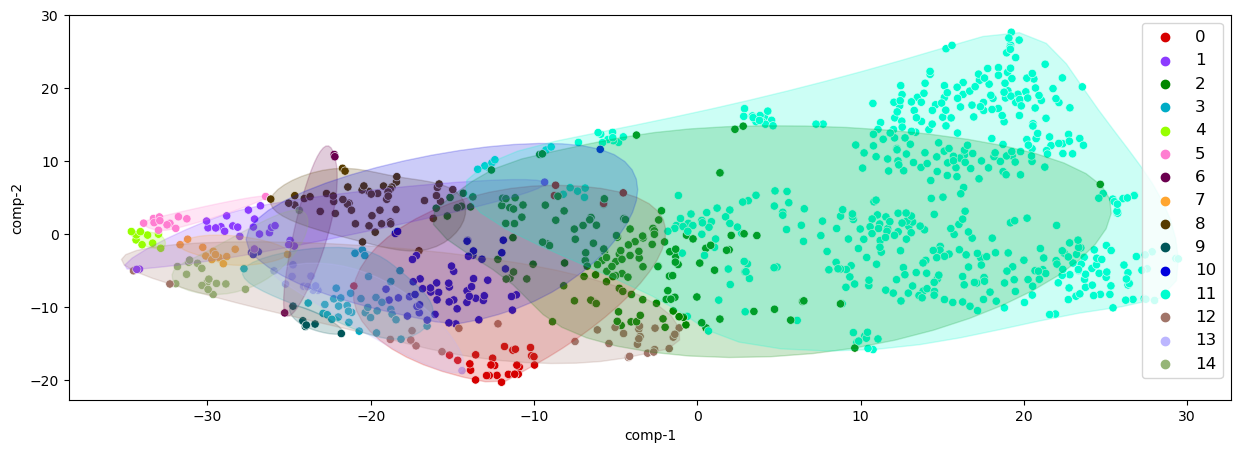

In [16]:
print(model, model_names_readable[model])

plot = 'initial'
training_type = 'repeated_training'

if plot == 'initial':
    print("Initial User Cluster Assignments")
    df_prev = apply_tsne_2d(environments[training_type]['actual_user_representation_initial'][model][0], environments[training_type]['user_cluster_assignments'][model][0], perplexity=perplexity)
    fig = plot_tsne(df_prev, perplexity, n_clusters, "Initial User Cluster Assignments")
    fig.show()
    # fig.savefig(f'/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/Figures/user_cluster_assignments/initial_user_cluster_assignments.jpg')

xquad_binary_0.25 Binary XquAD, alpha=0.25
repeated_training 
	No. final clusters= 7 
	Final clusters represented= [ 0  1  2  6 11 12 13]
single_training 
	No. final clusters= 6 
	Final clusters represented= [ 0  2  8 11 12 13]


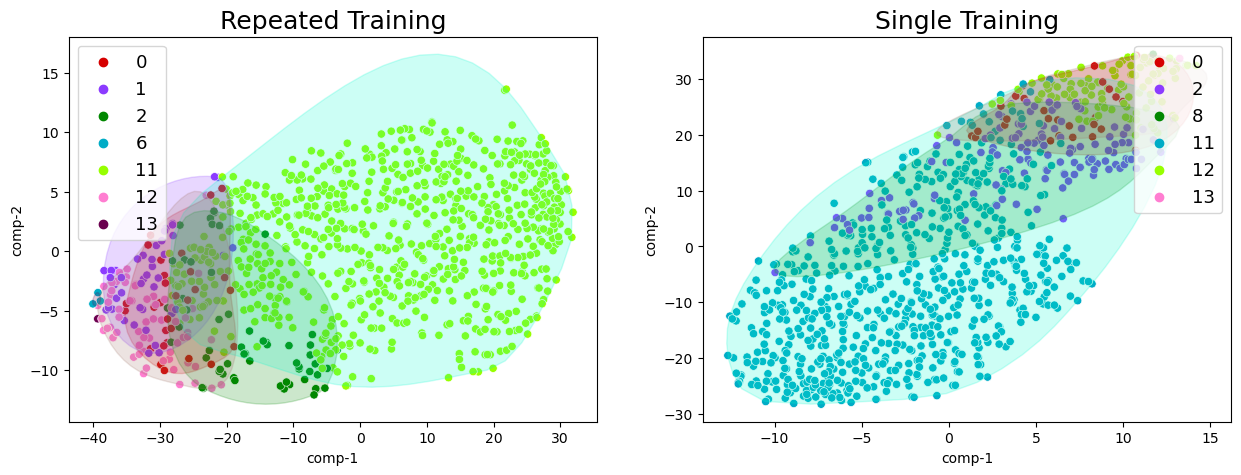

In [18]:
print(model, model_names_readable[model])
df_list = []
titles = []
for training_type in ['repeated_training', 'single_training']:
    user_rep_final = environments[training_type]['actual_user_representation_final'][model][0]
    user_assignment_final = user_topic_mapping_func(user_rep_final, environments[training_type]['user_cluster_centroids'][model][0])
    final_clusters_repr = np.unique(user_assignment_final)
    print(training_type, "\n\tNo. final clusters=", final_clusters_repr.size, "\n\tFinal clusters represented=", final_clusters_repr)
    df_rep_post = apply_tsne_2d(user_rep_final, user_assignment_final, perplexity=perplexity)
    df_list.append(df_rep_post)
    titles.append(training_readable[training_type])
    
fig = plot_tsne_comparison(df_list, n_clusters, titles)
fig.show()
# fig.savefig(f'/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/Figures/user_cluster_assignments/{model}_final_user_cluster_assignments.jpg')


## Plotting user-topic mapping

In [22]:
model = model_keys[0]
n_clusters=15
print(model, model_names_readable[model])

baseline_myopic Myopic


baseline_myopic Myopic
Initial User-Topic Mapping


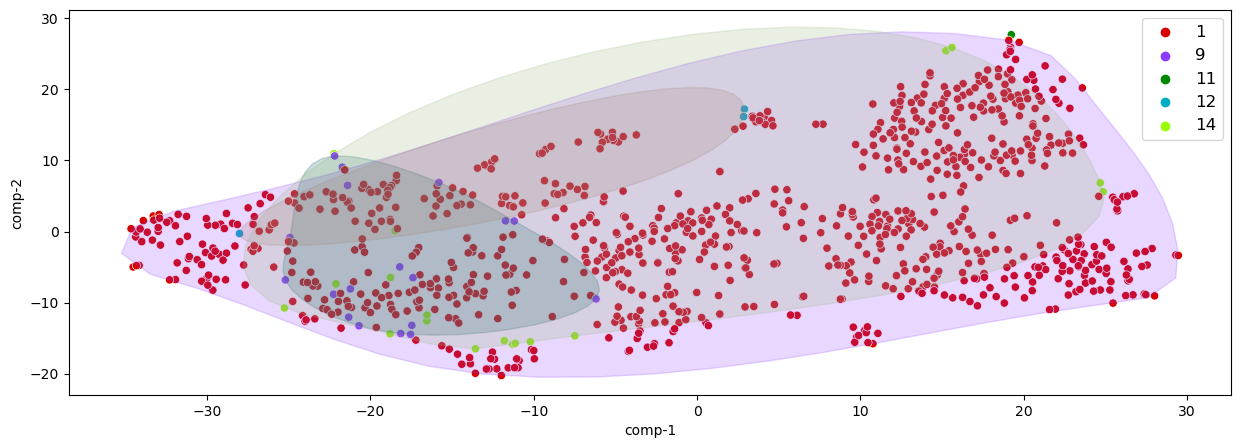

In [24]:
# plot = 'final'
plot = 'initial'
training_type = 'repeated_training'
print(model, model_names_readable[model])

if plot == 'initial':
    print("Initial User-Topic Mapping")
    df_prev = apply_tsne_2d(environments[training_type]['actual_user_representation_initial'][model][0], environments[training_type]['user_item_cluster_mapping'][model][0], perplexity=perplexity)
    fig = plot_tsne(df_prev, perplexity, n_clusters, "Initial User Cluster Assignments")
    fig.show()
    # fig.savefig(f'/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/Figures/user_topic_mapping/initial_user_topic_mapping.jpg')

baseline_myopic Myopic
repeated_training 
	No. final clusters= 9 
	Final clusters represented= [ 0  1  4  5  9 11 12 13 14]
single_training 
	No. final clusters= 9 
	Final clusters represented= [ 0  1  4  5  9 11 12 13 14]
True


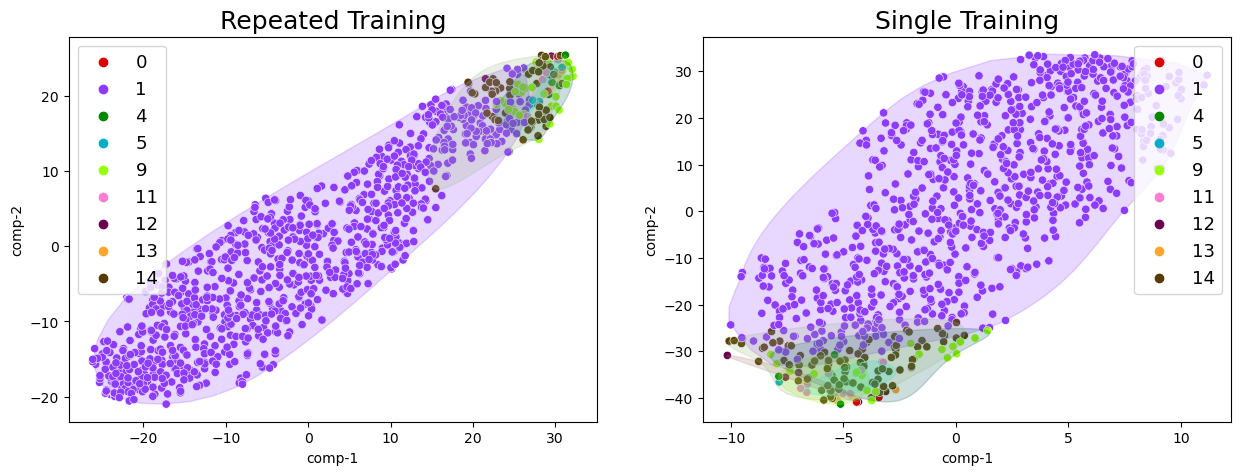

In [25]:
print(model, model_names_readable[model])
df_list = []
titles = []
user_cluster_repr = []
for training_type in ['repeated_training', 'single_training']:
    user_rep_final = environments[training_type]['actual_user_representation_final'][model][0]
    user_assignment_final = user_topic_mapping_func(user_rep_final, environments[training_type]['item_cluster_centroids'][model][0])
    final_clusters_repr = np.unique(user_assignment_final)
    print(training_type, "\n\tNo. final clusters=", final_clusters_repr.size, "\n\tFinal clusters represented=", final_clusters_repr)
    user_cluster_repr.append(final_clusters_repr)
    df_rep_post = apply_tsne_2d(user_rep_final, user_assignment_final, perplexity=perplexity)
    df_list.append(df_rep_post)
    titles.append(training_readable[training_type])
    
fig = plot_tsne_comparison(df_list, n_clusters, titles)
fig.show()
print(np.array_equal(user_cluster_repr[0], user_cluster_repr[1]))
# fig.savefig(f'/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/Figures/user_topic_mapping/{model}_final_user_topic_mapping.jpg')
